In [384]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
from PIL import ImageEnhance
from PIL import ImageOps
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [385]:
# 2. 定义CNN模型（与之前相同）
class DigitCNN(nn.Module):
    def __init__(self):
        super(DigitCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DigitCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = DigitCNN().to(device)
model.load_state_dict(torch.load('digit_cnn.pth', map_location=device))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21260\1012956635.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('digit_cnn.pth', m

<All keys matched successfully>

In [386]:
# 1. 定义数据预处理
transform = transforms.Compose([
    transforms.Grayscale(),  # 确保图像是灰度图
    transforms.Resize((28, 28)),  # 调整到28x28
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [387]:
def mnist_style_preprocess(image_path):
    # 1. 打开图片并转为灰度
    image = Image.open(image_path).convert('L')
    # 增强对比度
    image = ImageEnhance.Contrast(image).enhance(2.0)  # 数值可调，2.0~3.0更明显

    # 2. 二值化
    image_np = np.array(image)
    threshold = 100  # 阈值调低一点，黑的更黑
    image_np = (image_np < threshold) * 255  # 黑底白字
    image_bin = Image.fromarray(np.uint8(image_np))

    # 3. 找到非白色区域（即数字）的边界
    coords = np.column_stack(np.where(image_np < 255))
    if coords.size == 0:
        # 没有数字，直接返回空白28x28
        return Image.new('L', (28, 28), 0)  # 黑底

    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    # 4. 裁剪出数字区域
    cropped = image_bin.crop((x_min, y_min, x_max + 1, y_max + 1))

    # 5. 缩放到26x26
    digit = cropped.resize((26, 26), Image.Resampling.LANCZOS)

    # 6. 新建28x28黑底图，把数字粘贴到中心
    new_img = Image.new('L', (28, 28), 0)  # 黑底
    upper_left = ((28 - 26) // 2, (28 - 26) // 2)
    new_img.paste(digit, upper_left)

    return new_img

In [388]:
# 7. 测试单张图片
def predict_image(image_path, model_path='digit_cnn.pth'):
    # 加载模型
    model = DigitCNN().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    image = mnist_style_preprocess(image_path)
    plt.show(image)  # 显示处理后的图片
    image = transform(image).unsqueeze(0).to(device)  # 添加batch维度

    # 预测
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        prediction = predicted.item()

    # 显示图片和预测结果
    plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
    plt.title(f'Predicted Digit: {prediction}')
    plt.axis('off')
    plt.show()
    print(f'Predicted Digit: {prediction}')


C:\Users\Administrator\AppData\Local\Temp\ipykernel_21260\1779484503.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loc

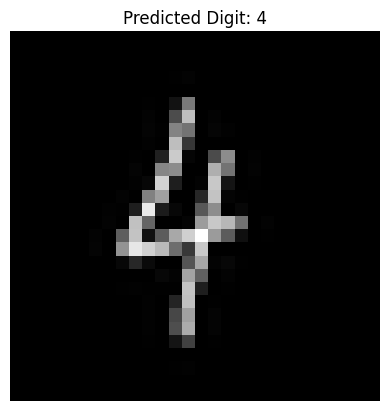

Predicted Digit: 4


In [389]:
predict_image('./test_image/(2).png')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21260\1779484503.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loc

预测图片: (1).png


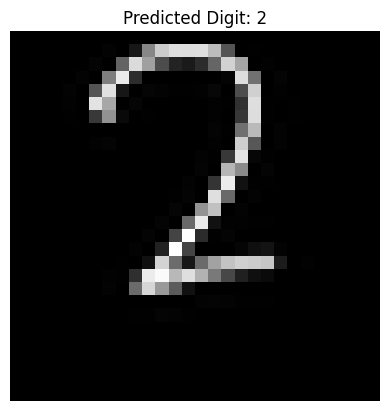

Predicted Digit: 2
预测图片: (2).png


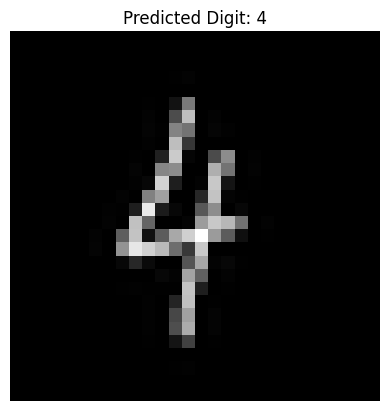

Predicted Digit: 4
预测图片: (3).png


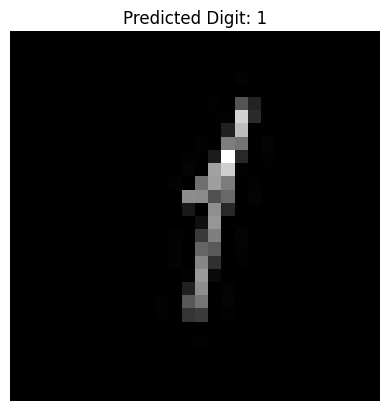

Predicted Digit: 1
预测图片: 8.png


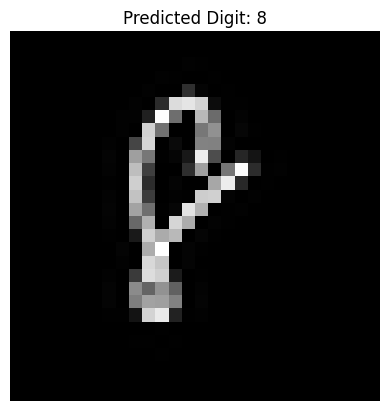

Predicted Digit: 8
预测图片: drawing.png


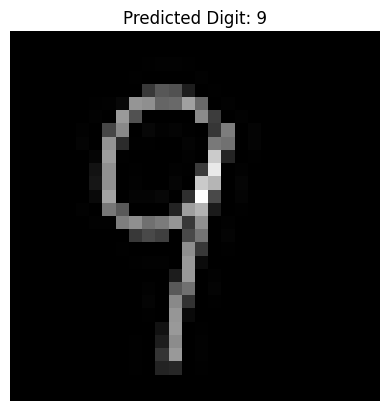

Predicted Digit: 9
预测图片: number1.jpg


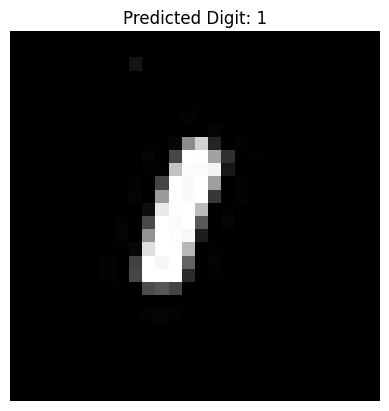

Predicted Digit: 1
预测图片: number3.jpg


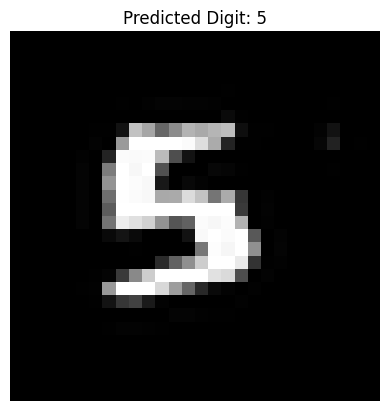

Predicted Digit: 5
预测图片: number4.jpg


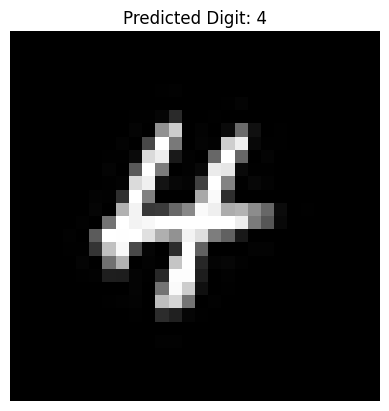

Predicted Digit: 4


In [390]:
import os
image_folder = './test_image'
for filename in os.listdir(image_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        image_path = os.path.join(image_folder, filename)
        print(f'预测图片: {filename}')
        predict_image(image_path)

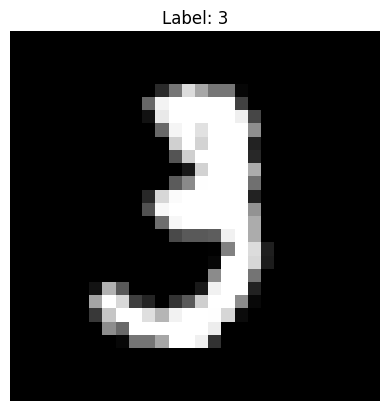

In [391]:
import torchvision
import matplotlib.pyplot as plt

# 下载并加载MNIST数据集
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True)

# 取出第0张图片和标签
image, label = mnist_train[10]

# 显示图片
plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()